# Bibliotecas Treinamento DenseNet121

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from collections import Counter
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub
# Download latest version
dataset_path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [ ]:
def load_dataset(dataset_path):
    """
    Carrega as imagens e r√≥tulos a partir da estrutura de diret√≥rios do dataset.

    Par√¢metros:
        dataset_path (str): Caminho para o diret√≥rio onde est√° o dataset

    Retorno:
        images (list): Lista com caminhos de cada imagem.
        labels (list): Lista com o √≠ndice da classe correspondente a cada imagem.
        class_map (dict): Dicion√°rio que mapeia o √≠ndice da classe para o nome da classe (pasta).
    """
    images = []
    labels = []
    class_map = {}

    # Define o caminho base para a pasta "covid19-radiography-database"
    base_path = os.path.join(dataset_path, 'COVID-19_Radiography_Dataset')
    # Lista as pastas dentro de base_path
    class_folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    # Itera sobre cada pasta de classe para mapear √≠ndices e carregar caminhos de imagem
    for idx, class_folder in enumerate(class_folders):
        class_path = os.path.join(base_path, class_folder)
        images_path = os.path.join(class_path, 'images')

        # Verifica se a pasta "images" existe dentro da pasta da classe
        if os.path.exists(images_path):
            class_map[idx] = class_folder  # Mapeia o √≠ndice da classe para o nome da classe
            # Para cada imagem, adiciona o caminho e o √≠ndice da classe √†s listas
            for image_filename in os.listdir(images_path):
                image_path = os.path.join(images_path, image_filename)
                images.append(image_path)
                labels.append(idx)

    return images, labels, class_map

# Defini√ß√£o de transforma√ß√µes para as imagens (aqui, 224x224 para DenseNet121)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona para 224x224 pixels
    transforms.ToTensor(),          # Converte a imagem para um tensor PyTorch
    transforms.Normalize(           # Normaliza o tensor com m√©dias e desvios padr√£o de ImageNet
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])


In [ ]:
class XRayDataset(Dataset):
    """
    Classe personalizada para carregar as imagens e r√≥tulos em um objeto Dataset.
    """
    def __init__(self, images, labels, transform=None):
        """
        Construtor do Dataset.

        Par√¢metros:
            images (list): Lista com caminhos de cada imagem.
            labels (list): Lista de r√≥tulos (√≠ndices das classes).
            transform (callable, opcional): Transforma√ß√µes aplicadas √†s imagens.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
        Retorna o tamanho do dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retorna a imagem e o r√≥tulo na posi√ß√£o idx.

        Par√¢metros:
            idx (int): √çndice do elemento a ser retornado.

        Retorno:
            img (Tensor): Imagem transformada em tensor.
            label (int): √çndice da classe correspondente √† imagem.
        """
        image_path = self.images[idx]
        label = self.labels[idx]
        # Abre a imagem e converte para RGB
        img = Image.open(image_path).convert('RGB')

        # Aplica transforma√ß√µes, se existirem
        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# Carrega todos os caminhos de imagem e r√≥tulos
images, labels, class_map = load_dataset(dataset_path)
dataset = XRayDataset(images, labels, transform=transform)

In [ ]:
# Separa o dataset em treino (80%) e valida√ß√£o (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
# Cria os DataLoaders para treino e valida√ß√£o
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Conta quantas imagens de cada classe h√° em cada conjunto (treino e valida√ß√£o)
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
val_labels = [val_dataset[i][1] for i in range(len(val_dataset))]

# Utiliza o Counter para contar a quantidade por classe
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Exibe a distribui√ß√£o de cada classe no conjunto de treino
print("Quantidade de imagens por classe no conjunto de TREINO:")
for idx, count in train_counts.items():
    print(f"{class_map[idx]}: {count} imagens")

# Exibe a distribui√ß√£o de cada classe no conjunto de valida√ß√£o
print("\nQuantidade de imagens por classe no conjunto de VALIDA√á√ÉO:")
for idx, count in val_counts.items():
    print(f"{class_map[idx]}: {count} imagens")

Quantidade de imagens por classe no conjunto de TREINO:
Normal: 8188 imagens
Lung_Opacity: 4819 imagens
COVID: 2845 imagens
Viral Pneumonia: 1080 imagens

Quantidade de imagens por classe no conjunto de VALIDA√á√ÉO:
COVID: 771 imagens
Viral Pneumonia: 265 imagens
Normal: 2004 imagens
Lung_Opacity: 1193 imagens


In [ ]:
# Carrega o modelo DenseNet121 pr√©-treinado
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.8M/30.8M [00:00<00:00, 175MB/s]


In [ ]:
# Ajusta a camada de sa√≠da (classifier) para o n√∫mero de classes do dataset
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_map))

In [ ]:
# Define a fun√ß√£o de perda (CrossEntropy) e o otimizador (Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

# Define o dispositivo (GPU se dispon√≠vel, sen√£o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Listas para acompanhar a evolu√ß√£o do treinamento
epochs_list = []
loss_list = []
accuracy_list = []

# Define o n√∫mero de √©pocas de treinamento (exemplo com 3)
num_epochs = 3
for epoch in range(num_epochs):
    # Coloca o modelo em modo de treino
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # L√™ os lotes de treino
    for images_batch, labels_batch in train_loader:
        # Move os tensores para GPU, se dispon√≠vel
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        # Zera os gradientes acumulados
        optimizer.zero_grad()
        # Faz a predi√ß√£o
        outputs = model(images_batch)
        # Calcula a perda
        loss = criterion(outputs, labels_batch)
        # Backpropagation
        loss.backward()
        # Atualiza os pesos
        optimizer.step()

        # Soma a perda para c√°lculo de m√©dia
        running_loss += loss.item()
        # Acur√°cia do batch
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

    # Calcula a perda m√©dia e acur√°cia ao final de cada √©poca
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct / total
    epochs_list.append(epoch + 1)
    loss_list.append(epoch_loss)
    accuracy_list.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Treinamento conclu√≠do!")

Epoch 1/3, Loss: 0.3251, Accuracy: 87.99%
Epoch 2/3, Loss: 0.2284, Accuracy: 91.80%
Epoch 3/3, Loss: 0.1963, Accuracy: 92.88%
Treinamento conclu√≠do!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Supondo que voc√™ crie uma pasta 'modelos' no drive
save_path = "/content/drive/MyDrive/Treinamento modelos Raio-x/Modelos treinados/DenseNet121_modelo_t.pth"
torch.save(model.state_dict(), save_path)

Mounted at /content/drive


In [ ]:
#Modelo ja treinado como recuperar:
import torch
import torchvision.models as models

# 1. Crie o modelo SEM usar a configura√ß√£o padr√£o (1000 classes).
#    Voc√™ pode usar weights=None ou weights=algum Peso do ImageNet,
#    mas o importante √© definir a camada final antes de carregar os pesos.
model = models.densenet121(weights=None)
num_ftrs = model.classifier.in_features

# 2. Ajuste para 4 classes (ou o n√∫mero que voc√™ treinou).
model.classifier = torch.nn.Linear(num_ftrs, 4)
model.load_state_dict(torch.load("/content/drive/MyDrive/Treinamento modelos Raio-x/Modelos treinados/DenseNet121_modelo_t.pth"))
model.eval()

<ipython-input-27-a7a798412681>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/Treinamento modelos Raio-x/Modelos

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

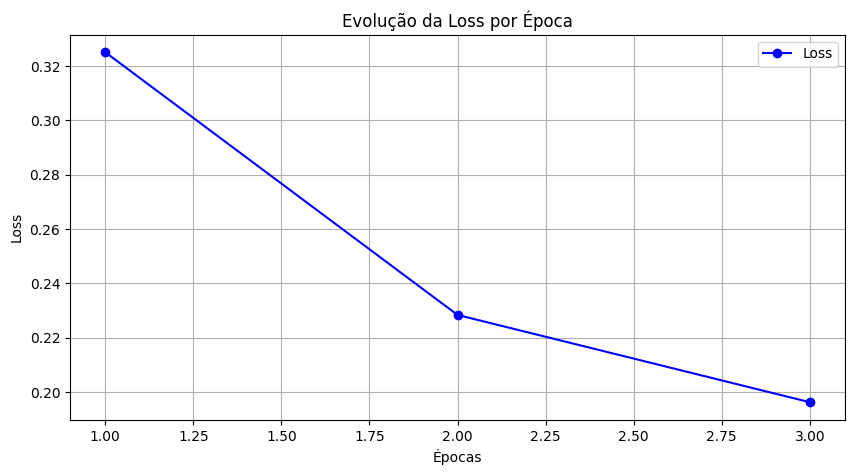

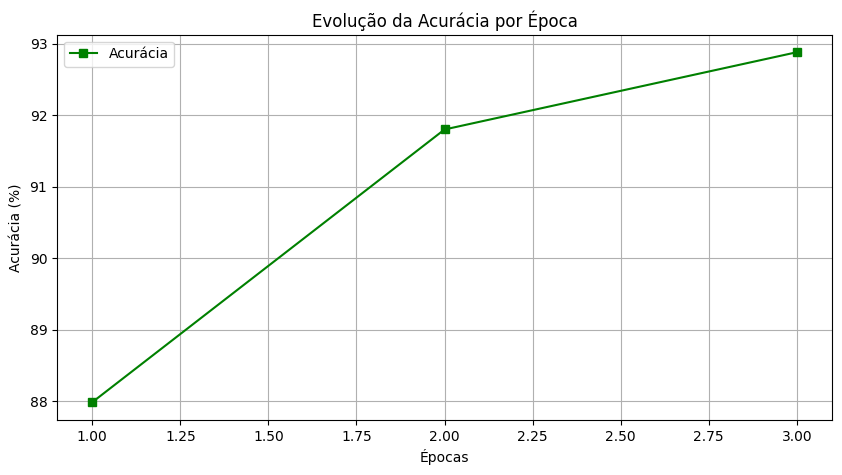

In [ ]:
# Gr√°fico da evolu√ß√£o da perda (Loss) por √©poca
plt.figure(figsize=(10,5))
plt.plot(epochs_list, loss_list, marker='o', linestyle='-', color='b', label='Loss')
plt.xlabel('√âpocas')
plt.ylabel('Loss')
plt.title('Evolu√ß√£o da Loss por √âpoca')
plt.legend()
plt.grid()
plt.show()

# Gr√°fico da evolu√ß√£o da acur√°cia por √©poca
plt.figure(figsize=(10,5))
plt.plot(epochs_list, accuracy_list, marker='s', linestyle='-', color='g', label='Acur√°cia')
plt.xlabel('√âpocas')
plt.ylabel('Acur√°cia (%)')
plt.title('Evolu√ß√£o da Acur√°cia por √âpoca')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Avalia√ß√£o do modelo (Valida√ß√£o)
model.eval()             # Coloca o modelo em modo de avalia√ß√£o
val_loss = 0.0
correct = 0
total = 0
val_losses = []
val_accuracies = []
class_correct = Counter()
class_total = Counter()
class_losses = Counter()
all_preds = []
all_labels = []


# Desabilita gradientes para a fase de valida√ß√£o (economia de mem√≥ria/c√°lculo)
with torch.no_grad():
    # Itera sobre os lotes do conjunto de valida√ß√£o
    for images_batch, labels_batch in val_loader:
        # Move para GPU se dispon√≠vel
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        # Forward
        outputs = model(images_batch)
        # Calcula perda de valida√ß√£o
        loss = criterion(outputs, labels_batch)
        val_loss += loss.item()

        # Calcula acertos
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

        # Armazena previs√µes e r√≥tulos para m√©tricas detalhadas
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

        # Contabiliza acertos e perdas por classe, para an√°lises de m√©tricas
        for i in range(labels_batch.size(0)):
            label = labels_batch[i].item()
            class_total[label] += 1
            class_losses[label] += loss.item()
            if predicted[i] == labels_batch[i]:
                class_correct[label] += 1

    # C√°lculo de m√©dia da perda e acur√°cia
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


Validation Loss: 0.2552, Accuracy: 91.71%



Matriz de Confus√£o:
[[1094   98    0    5]
 [ 104 1887   15    3]
 [  11    7  259    2]
 [  58   47    3  640]]

Relat√≥rio de Classifica√ß√£o:
Lung_Opacity: Precision: 0.86, Recall: 0.91, F1-score: 0.89, Support: 1197.0
Normal: Precision: 0.93, Recall: 0.94, F1-score: 0.93, Support: 2009.0
Viral Pneumonia: Precision: 0.94, Recall: 0.93, F1-score: 0.93, Support: 279.0
COVID: Precision: 0.98, Recall: 0.86, F1-score: 0.92, Support: 748.0
macro avg: Precision: 0.93, Recall: 0.91, F1-score: 0.92, Support: 4233.0
weighted avg: Precision: 0.92, Recall: 0.92, F1-score: 0.92, Support: 4233.0

Acur√°cia por classe:
Classe Lung_Opacity: Acur√°cia: 91.40%, Loss: 0.2404
Classe Normal: Acur√°cia: 93.93%, Loss: 0.2312
Classe COVID: Acur√°cia: 85.56%, Loss: 0.2411
Classe Viral Pneumonia: Acur√°cia: 92.83%, Loss: 0.2442


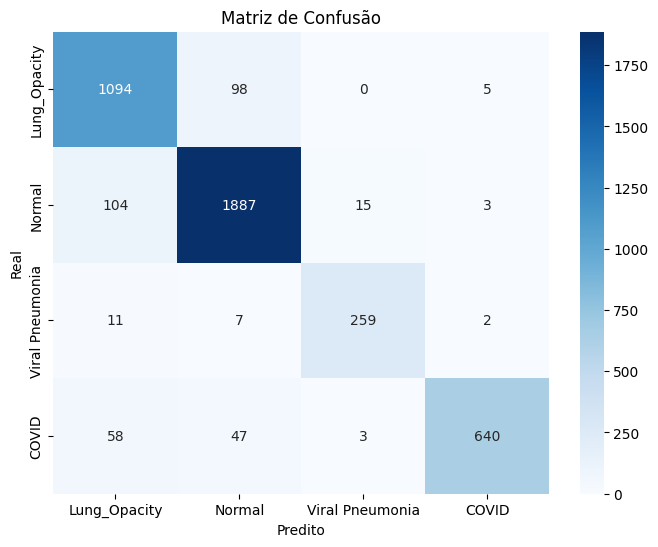

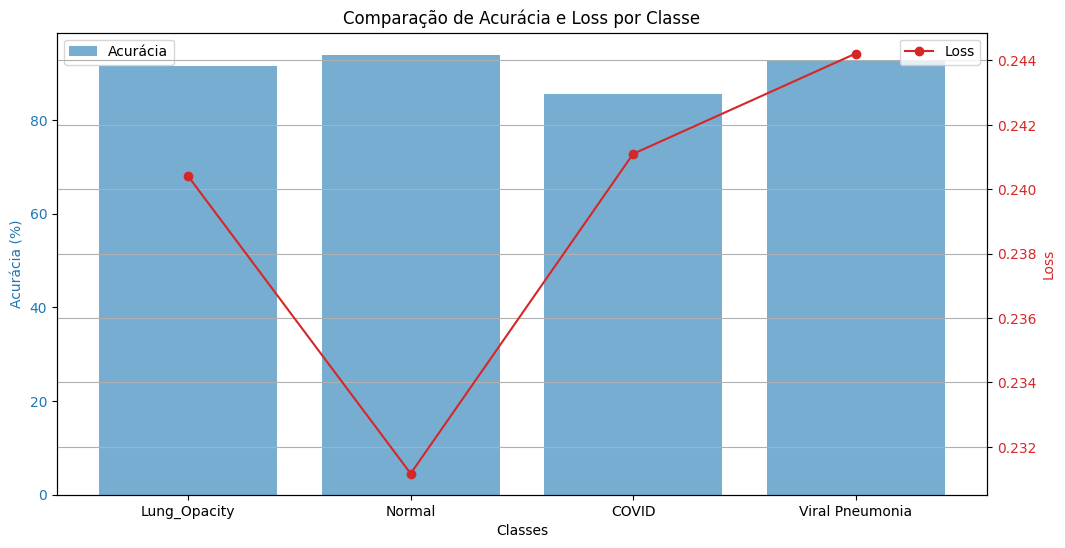

In [ ]:
# C√°lculo da Matriz de Confus√£o e Relat√≥rio de Classifica√ß√£o
cm = confusion_matrix(all_labels, all_preds)
classification_rep = classification_report(
    all_labels,
    all_preds,
    target_names=class_map.values(),
    output_dict=True
)

# Exibe a Matriz de Confus√£o
print("\nMatriz de Confus√£o:")
print(cm)

# Exibe o Relat√≥rio de Classifica√ß√£o (precision, recall, f1-score, etc.)
print("\nRelat√≥rio de Classifica√ß√£o:")
for class_label, metrics in classification_rep.items():
    # Verifica se o item √© um dicion√°rio para imprimir m√©tricas espec√≠ficas de classe
    if isinstance(metrics, dict):
        print(f"{class_label}: "
              f"Precision: {metrics['precision']:.2f}, "
              f"Recall: {metrics['recall']:.2f}, "
              f"F1-score: {metrics['f1-score']:.2f}, "
              f"Support: {metrics['support']}")

# Calcula a acur√°cia por classe, bem como a m√©dia de perda (Loss) por classe
class_names = [class_map[idx] for idx in class_total.keys()]
class_accuracies = [
    100.0 * class_correct[idx] / class_total[idx] if class_total[idx] > 0 else 0
    for idx in class_total.keys()
]
class_losses_avg = [
    class_losses[idx] / class_total[idx] if class_total[idx] > 0 else 0
    for idx in class_total.keys()
]

# Exibe a acur√°cia por classe
print("\nAcur√°cia por classe:")
for name, acc, loss_val in zip(class_names, class_accuracies, class_losses_avg):
    print(f"Classe {name}: Acur√°cia: {acc:.2f}%, Loss: {loss_val:.4f}")

# Plot da Matriz de Confus√£o com heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_map.values(),
            yticklabels=class_map.values())
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confus√£o")
plt.show()

# Gr√°fico comparativo de Acur√°cia e Loss por Classe
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Classes')
ax1.set_ylabel('Acur√°cia (%)', color='tab:blue')
# Barra para acur√°cia
ax1.bar(class_names, class_accuracies, color='tab:blue', alpha=0.6, label='Acur√°cia')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Segundo eixo Y para exibir o Loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
# Linha para o Loss
ax2.plot(class_names, class_losses_avg, marker='o', linestyle='-', color='tab:red', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('Compara√ß√£o de Acur√°cia e Loss por Classe')
plt.xticks(rotation=45)
plt.grid()
plt.show()


Validation Loss: 0.2552, Accuracy: 91.71%

Matriz de Confus√£o:
[[1965   37    1    1]
 [ 192  989    0   12]
 [  28    3  229    5]
 [  56   15    1  699]]

Relat√≥rio de Classifica√ß√£o:
Normal: Precision: 0.88, Recall: 0.98, F1-score: 0.93, Suporte: 2004.0
Lung_Opacity: Precision: 0.95, Recall: 0.83, F1-score: 0.88, Suporte: 1193.0
Viral Pneumonia: Precision: 0.99, Recall: 0.86, F1-score: 0.92, Suporte: 265.0
COVID: Precision: 0.97, Recall: 0.91, F1-score: 0.94, Suporte: 771.0
macro avg: Precision: 0.95, Recall: 0.90, F1-score: 0.92, Suporte: 4233.0
weighted avg: Precision: 0.92, Recall: 0.92, F1-score: 0.92, Suporte: 4233.0

Acur√°cia por classe:
Classe Normal: Acur√°cia: 98.05%, Loss: 0.2481
Classe Lung_Opacity: Acur√°cia: 82.90%, Loss: 0.2665
Classe Viral Pneumonia: Acur√°cia: 86.42%, Loss: 0.2664
Classe COVID: Acur√°cia: 90.66%, Loss: 0.2596


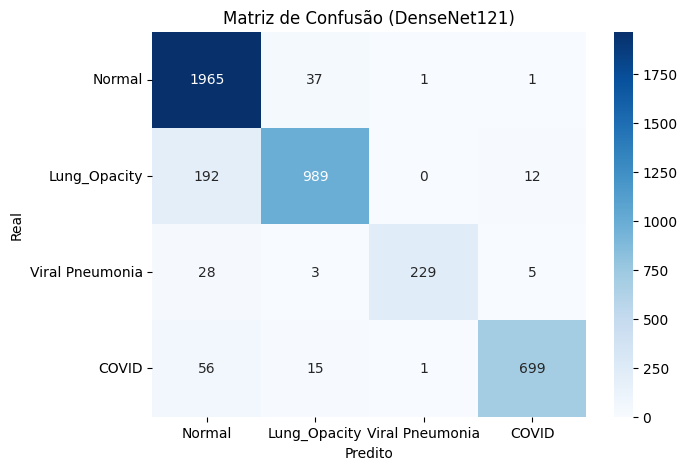


‚úÖ Conformal Prediction Manual:
Cobertura (acerto): 0.93 (com 95% de confian√ßa)
Tamanho m√©dio do conjunto predito: 1.05


In [ ]:
##################################
# (6) VALIDA√á√ÉO + COLETA DE PROBS
##################################
import torch.nn.functional as F

model.eval()
val_loss = 0.0
correct = 0
total = 0

from collections import defaultdict
class_correct = defaultdict(int)
class_total = defaultdict(int)
class_losses = defaultdict(float)

all_preds = []
all_labels = []
all_probs = []  # <- Para armazenar probabilidades (softmax)

with torch.no_grad():
    for images_batch, labels_batch in val_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)

        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        val_loss += loss.item()

        # Calcula probabilidades via softmax
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())  # Armazena p/ Conformal

        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

        # Armazena predi√ß√µes e r√≥tulos
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

        # C√°lculo de acur√°cia e perda por classe
        for i in range(labels_batch.size(0)):
            label = labels_batch[i].item()
            class_total[label] += 1
            class_losses[label] += loss.item()
            if predicted[i] == label:
                class_correct[label] += 1

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100.0 * correct / total

print(f"\nValidation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# Matriz de Confus√£o
cm = confusion_matrix(all_labels, all_preds)
print("\nMatriz de Confus√£o:")
print(cm)

# Relat√≥rio de Classifica√ß√£o
class_names_list = [class_map[idx] for idx in sorted(class_map.keys())]
classification_rep = classification_report(
    all_labels,
    all_preds,
    target_names=class_names_list,
    output_dict=True
)

print("\nRelat√≥rio de Classifica√ß√£o:")
for class_label, metrics in classification_rep.items():
    if isinstance(metrics, dict):
        print(f"{class_label}: "
              f"Precision: {metrics['precision']:.2f}, "
              f"Recall: {metrics['recall']:.2f}, "
              f"F1-score: {metrics['f1-score']:.2f}, "
              f"Suporte: {metrics['support']}")

# Acur√°cia e Loss por classe
print("\nAcur√°cia por classe:")
for idx in sorted(class_total.keys()):
    acc = 100.0 * class_correct[idx] / class_total[idx] if class_total[idx] > 0 else 0
    loss_val = class_losses[idx] / class_total[idx] if class_total[idx] > 0 else 0
    print(f"Classe {class_map[idx]}: Acur√°cia: {acc:.2f}%, Loss: {loss_val:.4f}")

# Plot da Matriz de Confus√£o
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_list,
            yticklabels=class_names_list)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confus√£o (DenseNet121)")
plt.show()

#############################################
# (7) PREDI√á√ÉO CONFORMAL MANUAL (SEM MAPIE)
#############################################
import numpy as np
from sklearn.model_selection import train_test_split

# Convertendo lista de probabilidades e labels para array NumPy
probs_np = np.array(all_probs)   # shape: (N, num_classes)
labels_np = np.array(all_labels) # shape: (N,)

# Separa ~20% do VAL para calibra√ß√£o
X_val_conf, X_calib, y_val_conf, y_calib = train_test_split(
    probs_np, labels_np, test_size=0.2, random_state=42
)

# 1) N√£o conformidade no conjunto de calibra√ß√£o = 1 - probabilidade da classe correta
nonconformity_scores = []
for i in range(len(X_calib)):
    prob = X_calib[i]         # ex: [0.1, 0.7, 0.2, ...]
    true_label = y_calib[i]   # √≠ndice da classe correta
    score = 1.0 - prob[true_label]
    nonconformity_scores.append(score)

nonconformity_scores = np.array(nonconformity_scores)
nonconformity_scores_sorted = np.sort(nonconformity_scores)

# 2) Define n√≠vel de confian√ßa (ex: alpha=0.05 -> 95% de confian√ßa)
alpha = 0.05
q_hat = np.quantile(nonconformity_scores_sorted, 1 - alpha)

# 3) Gerar conjuntos preditos (prediction sets) para o resto da valida√ß√£o
prediction_sets = []
correct_in_set = 0

for i in range(len(X_val_conf)):
    prob = X_val_conf[i]
    # Classes cuja n√£o conformidade (1 - prob[j]) <= q_hat
    pred_set = [j for j in range(len(prob)) if 1.0 - prob[j] <= q_hat]
    prediction_sets.append(pred_set)

    # Verifica se a classe real est√° no conjunto
    if y_val_conf[i] in pred_set:
        correct_in_set += 1

coverage = correct_in_set / len(X_val_conf)
avg_set_size = np.mean([len(ps) for ps in prediction_sets])

print("\n‚úÖ Conformal Prediction Manual:")
print(f"Cobertura (acerto): {coverage:.2f} (com 95% de confian√ßa)")
print(f"Tamanho m√©dio do conjunto predito: {avg_set_size:.2f}")

# Exemplo adicional: Voc√™ pode repetir para outros valores de alpha,
# para ver como muda a cobertura e o tamanho do conjunto predito.

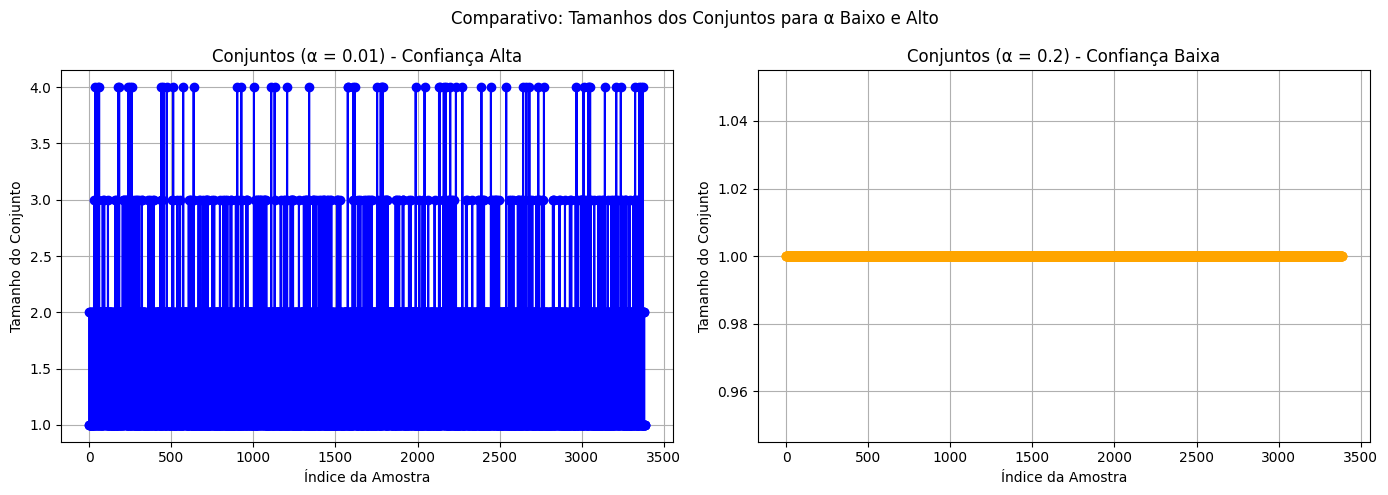


üìã Tabela: Frequ√™ncia dos Tamanhos (Confian√ßa Alta - Œ± = 0.01)
 Tamanho do Conjunto (Œ± = 0.01)  Quantidade
                              1        1825
                              2        1292
                              3         211
                              4          58

üìã Tabela: Frequ√™ncia dos Tamanhos (Confian√ßa Baixa - Œ± = 0.20)
 Tamanho do Conjunto (Œ± = 0.20)  Quantidade
                              1        3386


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Supondo que all_probs e all_labels j√° tenham sido definidos durante a valida√ß√£o
X_val_conf, X_calib, y_val_conf, y_calib = train_test_split(
    np.array(all_probs), np.array(all_labels), test_size=0.2, random_state=42
)

# Fun√ß√£o para gerar conjuntos de predi√ß√£o

def generate_prediction_sets(X_probs, y_true, nonconformity_scores, alpha):
    q_hat = np.quantile(nonconformity_scores, 1 - alpha)
    prediction_sets = []
    correct_in_set = 0

    for i in range(len(X_probs)):
        prob = X_probs[i]
        pred_set = [j for j in range(len(prob)) if 1.0 - prob[j] <= q_hat]

        # Corre√ß√£o: se conjunto estiver vazio, incluir a classe de maior probabilidade
        if len(pred_set) == 0:
            pred_set = [int(np.argmax(prob))]

        prediction_sets.append(pred_set)
        if y_true[i] in pred_set:
            correct_in_set += 1

    coverage = correct_in_set / len(X_probs)
    avg_size = np.mean([len(s) for s in prediction_sets])
    return prediction_sets, coverage, avg_size

# Etapa 1: calcular n√£o conformidade para calibra√ß√£o
nonconformity_scores = [1 - X_calib[i][y_calib[i]] for i in range(len(X_calib))]

# Testar alpha menos permissivo (maior confian√ßa)
alpha_low = 0.01
sets_low, cov_low, avg_low = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, alpha_low)
set_sizes_low = [len(s) for s in sets_low]

# Testar alpha mais permissivo (menor confian√ßa)
alpha_high = 0.20
sets_high, cov_high, avg_high = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, alpha_high)
set_sizes_high = [len(s) for s in sets_high]

# Gr√°ficos
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(range(len(set_sizes_low)), set_sizes_low, marker='o', linestyle='-', color='blue')
axs[0].set_title(f"Conjuntos (Œ± = {alpha_low}) - Confian√ßa Alta")
axs[0].set_xlabel("√çndice da Amostra")
axs[0].set_ylabel("Tamanho do Conjunto")
axs[0].grid(True)

axs[1].plot(range(len(set_sizes_high)), set_sizes_high, marker='o', linestyle='-', color='orange')
axs[1].set_title(f"Conjuntos (Œ± = {alpha_high}) - Confian√ßa Baixa")
axs[1].set_xlabel("√çndice da Amostra")
axs[1].set_ylabel("Tamanho do Conjunto")
axs[1].grid(True)

plt.suptitle("Comparativo: Tamanhos dos Conjuntos para Œ± Baixo e Alto")
plt.tight_layout()
plt.show()

# Tabelas comparativas
unique_low, count_low = np.unique(set_sizes_low, return_counts=True)
df_low = pd.DataFrame({
    "Tamanho do Conjunto (Œ± = 0.01)": unique_low,
    "Quantidade": count_low
})

unique_high, count_high = np.unique(set_sizes_high, return_counts=True)
df_high = pd.DataFrame({
    "Tamanho do Conjunto (Œ± = 0.20)": unique_high,
    "Quantidade": count_high
})

print("\nüìã Tabela: Frequ√™ncia dos Tamanhos (Confian√ßa Alta - Œ± = 0.01)")
print(df_low.to_string(index=False))

print("\nüìã Tabela: Frequ√™ncia dos Tamanhos (Confian√ßa Baixa - Œ± = 0.20)")
print(df_high.to_string(index=False))


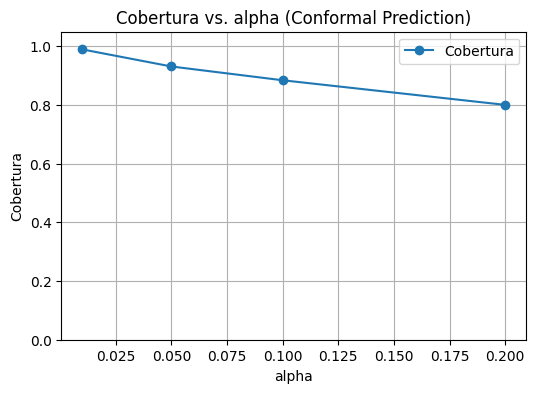

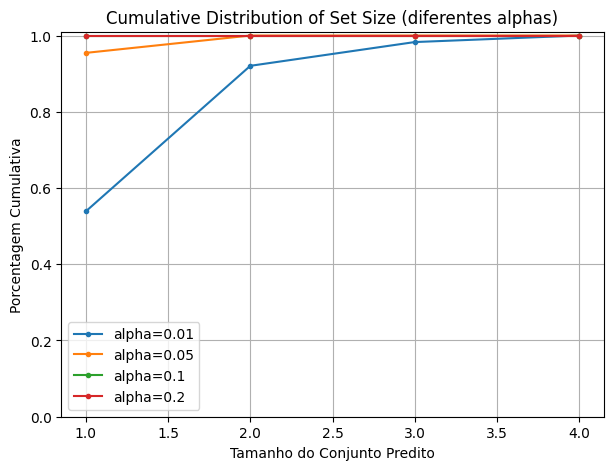

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Supomos que voc√™ J√Å possua:
# X_calib, y_calib, X_val_conf, y_val_conf
# onde:
# - X_calib: probabilidades softmax do conjunto de calibra√ß√£o
# - y_calib: r√≥tulos corretos do conjunto de calibra√ß√£o
# - X_val_conf: probabilidades softmax do conjunto de valida√ß√£o (exceto calibra√ß√£o)
# - y_val_conf: r√≥tulos corretos do conjunto de valida√ß√£o
# -------------------------------------------------

def compute_prediction_sets(probs_val, q_hat):
    """
    Retorna a lista de conjuntos preditos, onde cada conjunto
    cont√©m as classes j cujo (1 - prob[j]) <= q_hat.
    """
    prediction_sets = []
    for prob in probs_val:
        pred_set = [j for j in range(len(prob)) if (1.0 - prob[j]) <= q_hat]
        prediction_sets.append(pred_set)
    return prediction_sets

def coverage_and_size(prediction_sets, true_labels):
    """
    Calcula a cobertura (percentual de vezes em que o r√≥tulo verdadeiro
    est√° no conjunto) e o tamanho m√©dio dos conjuntos.
    """
    correct_in_set = 0
    for pset, true_label in zip(prediction_sets, true_labels):
        if true_label in pset:
            correct_in_set += 1
    coverage = correct_in_set / len(true_labels)
    avg_size = np.mean([len(pset) for pset in prediction_sets])
    return coverage, avg_size

# 1) Calcular n√£o conformidade no conjunto de calibra√ß√£o (1 - prob da classe correta)
scores_calib = 1.0 - np.array([X_calib[i, y_calib[i]] for i in range(len(X_calib))])
scores_calib_sorted = np.sort(scores_calib)

# 2) Escolher m√∫ltiplos valores de alpha para ver o efeito
alpha_values = [0.01, 0.05, 0.1, 0.2]  # Exemplo
coverages = []
avg_sizes = []

# Para plot de Cumulative Distribution of Set Size
cdf_data = {}  # dict alpha -> array com tamanhos

N_val = len(X_val_conf)  # n√∫mero de amostras na parte de valida√ß√£o

for alpha in alpha_values:
    # Determinar o quantil q_hat
    q_hat = np.quantile(scores_calib_sorted, 1 - alpha)

    # Formar conjuntos preditos
    prediction_sets = compute_prediction_sets(X_val_conf, q_hat)

    # Cobertura e tamanho m√©dio
    coverage, avg_size = coverage_and_size(prediction_sets, y_val_conf)
    coverages.append(coverage)
    avg_sizes.append(avg_size)

    # Vamos tamb√©m guardar o tamanho de cada conjunto predito para plot de distribui√ß√£o
    set_sizes = [len(ps) for ps in prediction_sets]
    cdf_data[alpha] = np.array(set_sizes)

####################################
# Plot 1: Coverage vs. alpha
####################################
plt.figure(figsize=(6,4))
plt.plot(alpha_values, coverages, marker='o', label='Cobertura')
plt.xlabel('alpha')
plt.ylabel('Cobertura')
plt.title('Cobertura vs. alpha (Conformal Prediction)')
plt.ylim([0, 1.05])
plt.grid()
plt.legend()
plt.show()

####################################
# Plot 2: Cumulative Distribution of Set Size
####################################
# Aqui, para cada alpha, calculamos a porcentagem cumulativa
# de exemplos que t√™m conjunto predito de tamanho <= k.

max_set_size = 0
for alpha in alpha_values:
    max_size_alpha = cdf_data[alpha].max()
    if max_size_alpha > max_set_size:
        max_set_size = max_size_alpha

# Vamos criar valores de x (tamanho do conjunto) de 1 at√© max_set_size.
x_vals = np.arange(1, max_set_size + 1)

plt.figure(figsize=(7,5))
for alpha in alpha_values:
    sizes = cdf_data[alpha]
    cdf = [(sizes <= k).mean() for k in x_vals]
    plt.plot(x_vals, cdf, marker='.', linestyle='-', label=f'alpha={alpha}')

plt.xlabel('Tamanho do Conjunto Predito')
plt.ylabel('Porcentagem Cumulativa')
plt.title('Cumulative Distribution of Set Size (diferentes alphas)')
plt.ylim([0,1.01])
plt.grid()
plt.legend()
plt.show()
